In [1]:
# import os; os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
import tensorflow as tf; tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-01 11:46:29.865293: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 11:46:30.352848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 4170 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


True

In [3]:
tf.__version__

'2.8.0'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU devices found. TensorFlow will run on CPU.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
## importing required packages
import numpy as np
from os import listdir
import tensorflow as tf
import keras
from  keras import layers
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [7]:
## CONFIGURATION 
EPOCHS = 5
BUFFER_SIZE = 2000
BATCH_SIZE = 2

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [8]:
# image_dir = "/content/drive/My Drive/3d printer/codes/datasets/cropped-datasets/"
# masks_dir = "/content/drive/My Drive/3d printer/codes/datasets/ground-truth/"

image_dir = "./All_images/"
masks_dir = "./All_masks/"

In [9]:
# import glob
# img_files = glob.glob(image_dir + '/**/*.jpg', recursive=True)
# mask_files = glob.glob(masks_dir + '/**/*.png', recursive=True)
# img_files[:10], mask_files[:10]

In [10]:
# choose on of the pairs of data and mask for dataset

img_folders = ['abyek_images', 'Khorasan_part1_images', 'Khorasan_part2_images', 'bound_images', 'orthophoto_images']
mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'Khorasan_part2_masks', 'bound_masks', 'orthophoto_masks']

# img_folders = ['abyek_images', 'Khorasan_part1_images', 'Khorasan_part2_images']
# mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'Khorasan_part2_masks']

# img_folders = ['abyek_images', 'Khorasan_part1_images',  'deliniation_images', 'bound_images']
# mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'deliniation_masks', 'bound_masks']

# img_folders = ['abyek_images']
# mask_folders = ['abyek_masks']


images_path, masks_path = [], []
# loop in pair of data and mask to make list of images and masks based on folder image
for fol, mfol in zip(img_folders, mask_folders):
    images_list = listdir(image_dir + fol)
    masks_list = listdir(masks_dir + mfol)

    img_list = [i.split('.jpg')[0] for i in images_list]
    msk_list = [i.split('.png')[0] for i in masks_list]

    commons = list(set(img_list) & set(msk_list))

    shuffle(commons)
    
    commons = commons[:1200]

    print(len(commons))

    ip =  [image_dir + fol + "/" + i + ".jpg"  for i in commons]
    mp  = [masks_dir + mfol + "/" + i + ".png"  for i in commons]
    # print(len(ip), len(mp))

    images_path.extend(ip)
    masks_path.extend(mp)
    # print(len(images_path), len(masks_path))

1155
1001
1200
1200
1200


In [11]:
images_path[:10], masks_path[:10] 

(['./All_images/abyek_images/993.jpg',
  './All_images/abyek_images/441.jpg',
  './All_images/abyek_images/1222.jpg',
  './All_images/abyek_images/1496.jpg',
  './All_images/abyek_images/666.jpg',
  './All_images/abyek_images/1625.jpg',
  './All_images/abyek_images/616.jpg',
  './All_images/abyek_images/212.jpg',
  './All_images/abyek_images/135.jpg',
  './All_images/abyek_images/1433.jpg'],
 ['./All_masks/abyek_masks/993.png',
  './All_masks/abyek_masks/441.png',
  './All_masks/abyek_masks/1222.png',
  './All_masks/abyek_masks/1496.png',
  './All_masks/abyek_masks/666.png',
  './All_masks/abyek_masks/1625.png',
  './All_masks/abyek_masks/616.png',
  './All_masks/abyek_masks/212.png',
  './All_masks/abyek_masks/135.png',
  './All_masks/abyek_masks/1433.png'])

In [12]:
def load_images(image_path, mask_path, img_size = (IMG_HEIGHT, IMG_WIDTH)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)
  img = img / 255.

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
  mask = mask / 255

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask, img_size, method = 'nearest')
  
  return img, mask

In [13]:
# make tensorflow dataset with given buffer size to fetch data in RAM based on buffer size 
dataset = tf.data.Dataset.from_tensor_slices((images_path, masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

2024-05-01 11:46:30.964835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4170 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5


In [14]:
def compute_sample_weights(image, mask):
	''' Compute sample weights for the image given class. '''
	# Compute relative weight of class
	class_weights = tf.constant([.5, 5.0])
	class_weights = class_weights/tf.reduce_sum(class_weights)

  	# Compute same-shaped Tensor as mask with sample weights per
  	# mask element. 
	sample_weights = tf.gather(class_weights, indices=tf.cast(mask, tf.int32))

	return image, mask, sample_weights

In [15]:
seed = 123
# divide our dataset into training and test set
val_dataset = (dataset
               .take(300)
               .prefetch(buffer_size=tf.data.AUTOTUNE) 
               )
train_dataset = (dataset
                .skip(300)
                .map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed)))
                .map(lambda image, label: (tf.image.random_flip_left_right(image, seed=seed), tf.image.random_flip_left_right(label, seed=seed)))
                .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=0.8), label))
                # .map(compute_sample_weights)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                .repeat(3)
                ) 
# train_dataset = train_dataset.map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed))).repeat(1)

In [16]:
train_dataset.cardinality().numpy()

7734

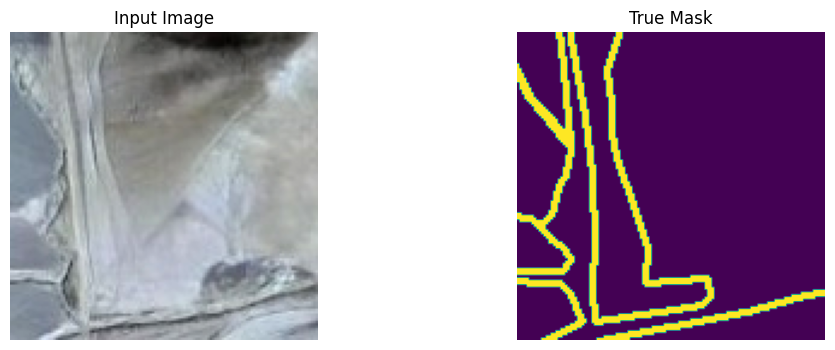

In [17]:
# plot images
def display(display_list, num_plot, flag=False):
  plt.figure(figsize=(12,4))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  if flag:
    plt.savefig(f"./Result_plots/result_deeplabv3_{num_plot}.png")
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask], False)
  

##  Model


In [18]:
# from DeepLabV3_Plus.deeplabv3plus.model.deeplabv3_plus import DeeplabV3Plus
# # from keras.models import load_weights

# # resmodel = load_weights("./resnet_model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

# model = DeeplabV3Plus(backbone='resnet50', num_classes=1)
# input_shape = (1, 128, 128, 3)
# # input_tensor = tf.random.normal(input_shape)
# result = model(input_shape)  # build model by one forward pass
# # model.summary()

In [19]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.resnet.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation = "sigmoid")(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model


In [20]:
# from keras.applications.resnet import ResNet50

filters = 32

model = DeeplabV3(IMG_HEIGHT, num_classes = 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [21]:
from tensorflow.keras.optimizers import Adam
import keras.backend as K



def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# calculate iou metric
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])


# compile the model 
model.compile(
     optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        # loss="mse",
        # loss = weightedLoss(keras.losses.binary_crossentropy, [1.0, 50.0]),
        metrics=["accuracy", "Precision", "Recall", f1_score],
        # sample_weight_mode="temporal",
  )

In [22]:
# make checkpoint to save model in each epoch
callbacks = [
    # ReduceLROnPlateau(patience=3, verbose=1),
    # EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('deeplabv3-model.h5', verbose=0, save_freq="epoch", save_best_only=True, save_weights_only=False)
    ]

In [23]:
# fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      # validation_steps = 8,
      # batch_size=BATCH_SIZE,
      callbacks = callbacks,
      # class_weight=class_weights,
      # sample_weight = [1.0, 2.0], 
    )

Epoch 1/5


2024-05-01 11:46:39.347397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907


7734/7734 [==============================] - 236s 29ms/step - loss: 0.1741 - accuracy: 0.9436 - precision: 0.5381 - recall: 0.0640 - f1_score: 0.0779 - val_loss: 0.2540 - val_accuracy: 0.9314 - val_precision: 0.3409 - val_recall: 0.0557 - val_f1_score: 0.0729
Epoch 2/5
7734/7734 [==============================] - 229s 29ms/step - loss: 0.1635 - accuracy: 0.9453 - precision: 0.6132 - recall: 0.1119 - f1_score: 0.1183 - val_loss: 0.2182 - val_accuracy: 0.9353 - val_precision: 0.2211 - val_recall: 6.0970e-04 - val_f1_score: 0.0012
Epoch 3/5
4525/7734 [================>.............] - ETA: 1:32 - loss: 0.1601 - accuracy: 0.9459 - precision: 0.6229 - recall: 0.1249 - f1_score: 0.1278

KeyboardInterrupt: 

In [ ]:
test_accuracy = model.evaluate(val_dataset, batch_size = BATCH_SIZE)
test_accuracy[1]

300/300 [==============================] - 4s 11ms/step - loss: 0.2508 - accuracy: 0.9318 - precision: 0.4559 - recall: 0.0194 - f1_score: 0.0346


0.9318112134933472

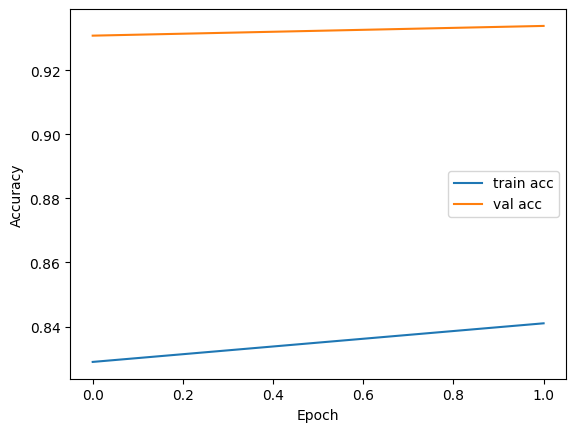

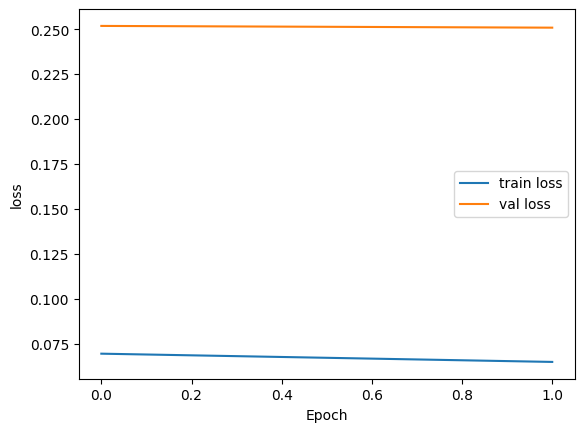

In [ ]:
# plot the accuracy and loss plots for train and test data

plt.plot(history.history["accuracy"], label='train acc')
plt.plot(history.history["val_accuracy"], label='val acc')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"./Result_plots/result_acc_deeplabv3.png")
plt.show()

plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='val loss')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig(f"./Result_plots/result_loss_deeplabv3.png")
plt.show()

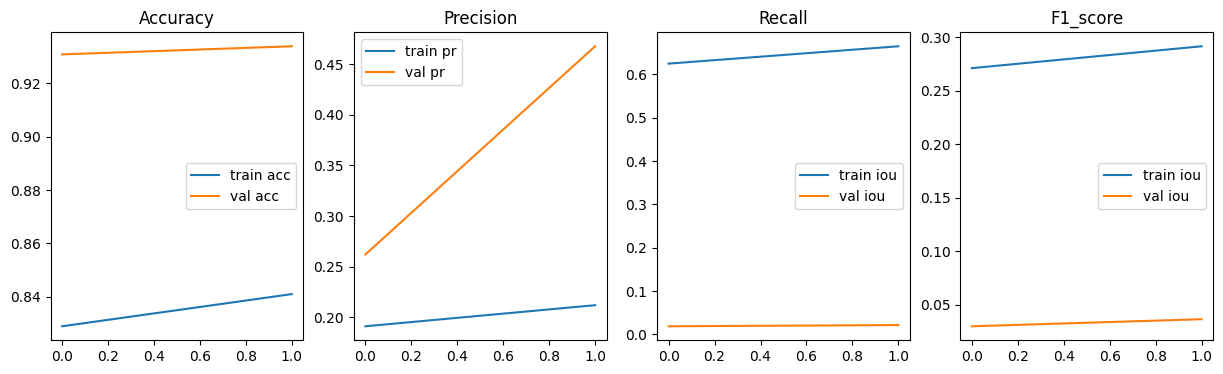

In [ ]:
# plot accuracy, precision and IOU  

fig , ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].plot(history.history["accuracy"], label='train acc')
ax[0].plot(history.history["val_accuracy"], label='val acc')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(history.history["precision"], label='train pr')
ax[1].plot(history.history["val_precision"], label='val pr')
ax[1].set_title('Precision')
ax[1].legend()

ax[2].plot(history.history["recall"], label='train iou')
ax[2].plot(history.history["val_recall"], label='val iou')
ax[2].set_title('Recall')
ax[2].legend()

ax[3].plot(history.history["f1_score"], label='train iou')
ax[3].plot(history.history["val_f1_score"], label='val iou')
ax[3].set_title('F1_score')
ax[3].legend()

plt.savefig(f"./Result_plots/result_deeplabv3.png")
plt.show()

In [ ]:
# create mask from predicted mask 
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    # threshold of 0.5 to differ labels from predicted mask
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        counter = 0
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            # print(pred_mask[0][pred_mask[0]>0.5])
            display([image[0], mask[0], create_mask(pred_mask)], counter, True)
            counter += 1
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

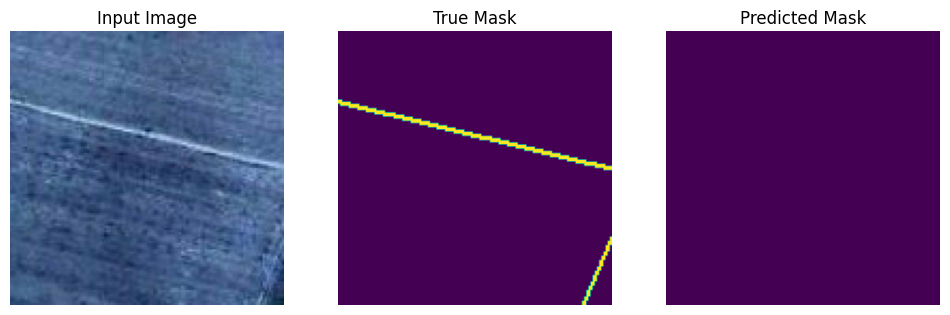

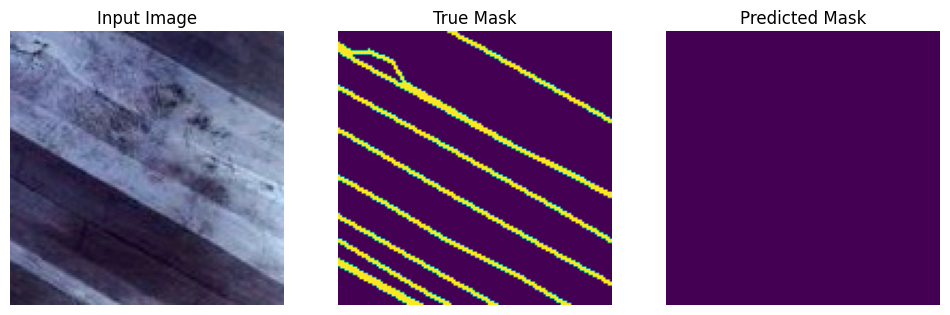

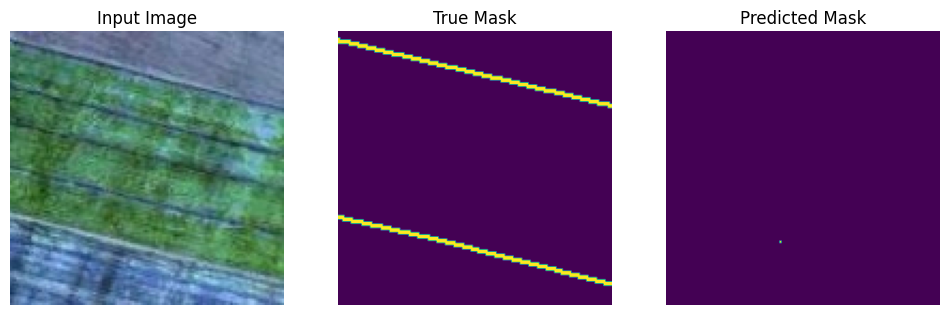

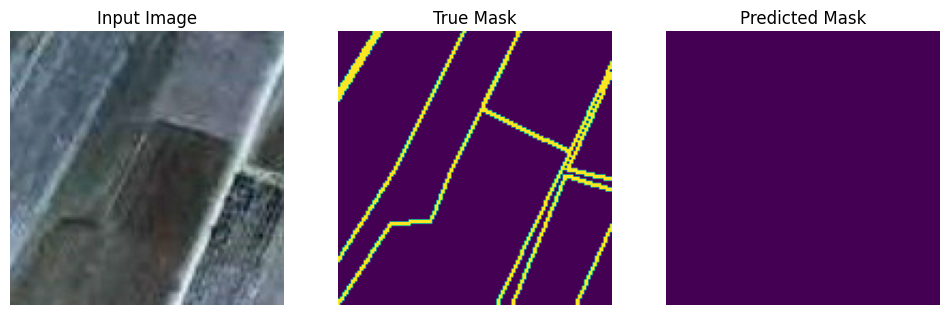

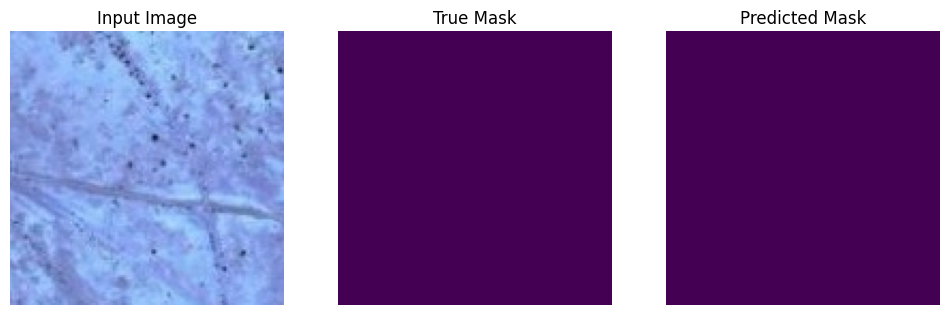

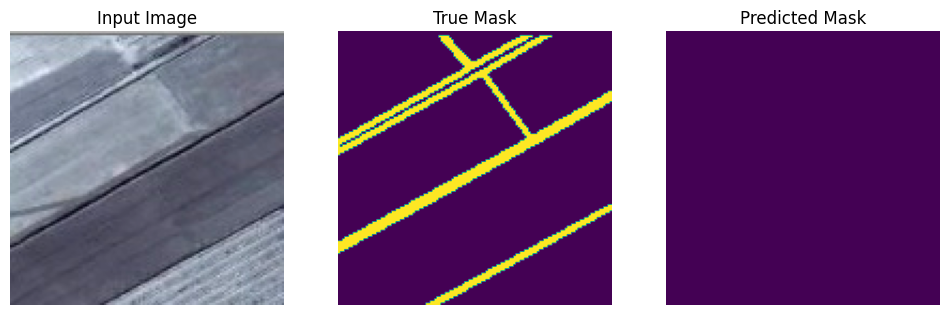

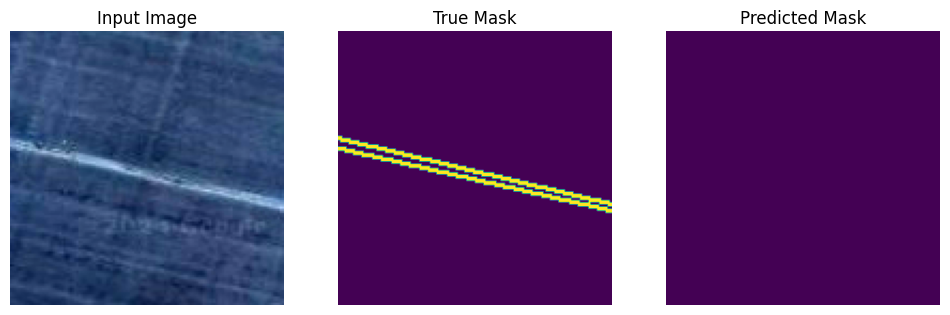

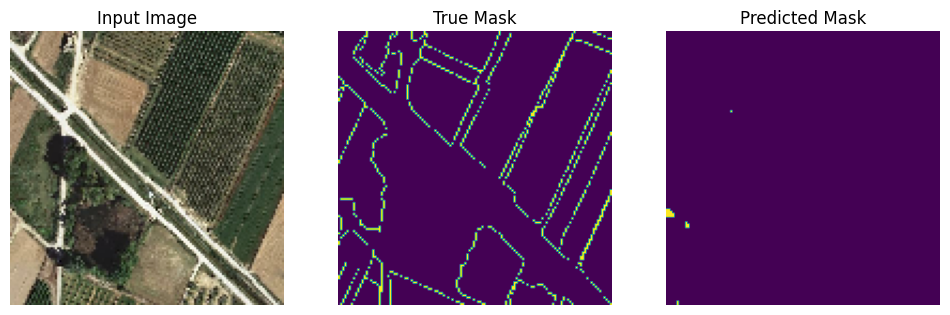

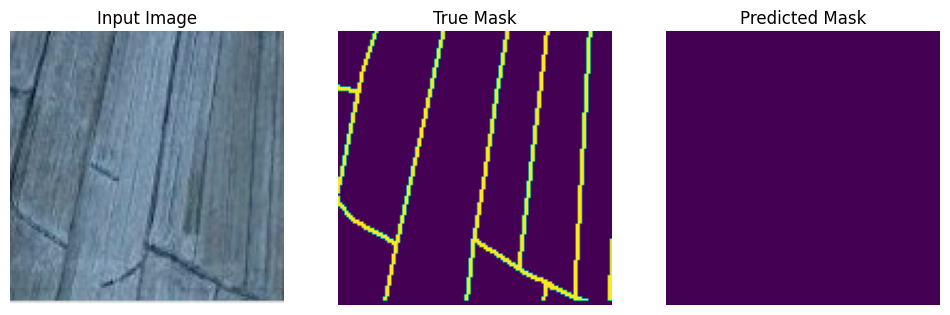

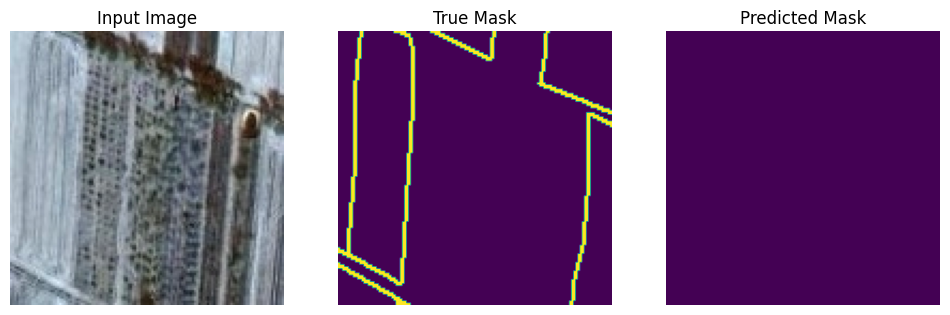

In [ ]:
## displaying our result
show_predictions(val_dataset,num=10)